In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm.notebook import tqdm, trange
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from google.colab import drive
import os
import numpy as np
import warnings
from torchvision import transforms
from torchsummary import summary
from torchvision.io import read_image
import time
warnings.filterwarnings('ignore')

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
zip_file_path = '/content/drive/MyDrive/ROP_datasets/annotations.zip'
# Распаковать архив в текущую папку
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
class ROP_Dataset(Dataset):
    def __init__(self, txt_file, image_dir, transform=None):
        self.image_list = pd.read_csv(txt_file, header=None)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_list.iloc[idx, 0])
        image = Image.open(img_path)
        img_tag = self.image_list.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
        sample = {"image": image, "tag": img_tag}

        return image, img_tag

In [5]:
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD  = torch.tensor([0.229, 0.224, 0.225])

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)  # Normaliztion
])

# Create Dataset Training
dataset_train = ROP_Dataset(txt_file='./annotations/train.txt', image_dir='./annotations/images', transform=transform)
# Create Dataset Testing
dataset_test = ROP_Dataset(txt_file='./annotations/test.txt', image_dir='./annotations/images', transform=transform)
# Create Dataset Validation
dataset_valid = ROP_Dataset(txt_file='./annotations/valid.txt', image_dir='./annotations/images', transform=transform)

# DataLoader Training
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
# DataLoader Testing
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)
# DataLoader Validation
dataloader_valid = DataLoader(dataset_valid, batch_size=32, shuffle=True)

print(next(iter(dataset_train)))

(tensor([[[-1.4329, -1.4500, -1.4672,  ..., -1.3644, -1.3302, -1.3130],
         [-1.4500, -1.4843, -1.4843,  ..., -1.3815, -1.3473, -1.3302],
         [-1.4672, -1.4843, -1.5185,  ..., -1.3815, -1.3302, -1.3302],
         ...,
         [-1.6213, -1.6555, -1.6727,  ..., -1.5870, -1.5699, -1.5528],
         [-1.6213, -1.6384, -1.6555,  ..., -1.5699, -1.5870, -1.5357],
         [-1.6213, -1.6384, -1.6384,  ..., -1.5528, -1.5357, -1.5185]],

        [[-1.5105, -1.5455, -1.5630,  ..., -1.4755, -1.4405, -1.4405],
         [-1.5280, -1.5630, -1.5805,  ..., -1.4580, -1.4230, -1.4055],
         [-1.5630, -1.5805, -1.5630,  ..., -1.4580, -1.4405, -1.4230],
         ...,
         [-1.5280, -1.5280, -1.5280,  ..., -1.4230, -1.4230, -1.4230],
         [-1.5105, -1.5280, -1.5105,  ..., -1.4580, -1.4230, -1.4055],
         [-1.4930, -1.5280, -1.5280,  ..., -1.4055, -1.4055, -1.3880]],

        [[-1.2990, -1.2293, -1.2641,  ..., -1.2990, -1.3339, -1.3513],
         [-1.2990, -1.2641, -1.2816,  ..., -

In [99]:
print(f'Number of training examples: {len(dataset_train)}')
print(f'Number of validation examples: {len(dataset_valid)}')

Number of training examples: 481
Number of validation examples: 70


In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [8]:
import torchvision.models as models
import torch.optim as optim

In [86]:
model = models.efficientnet_b0(weights='IMAGENET1K_V1', progress=True).to(device)

In [91]:
summary(model, input_size = (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [90]:
params = list(model.named_parameters())

# print(params)
for idx in range(len(params)):
    print(params[idx][0],'\t', params[idx][1].size())
print('\n',10*'--')
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

num_params = sum(p.numel() for p in model.parameters() )
print('Number of all parameters for the model: %d' % (num_params))

features.0.0.weight 	 torch.Size([32, 3, 3, 3])
features.0.1.weight 	 torch.Size([32])
features.0.1.bias 	 torch.Size([32])
features.1.0.block.0.0.weight 	 torch.Size([32, 1, 3, 3])
features.1.0.block.0.1.weight 	 torch.Size([32])
features.1.0.block.0.1.bias 	 torch.Size([32])
features.1.0.block.1.fc1.weight 	 torch.Size([8, 32, 1, 1])
features.1.0.block.1.fc1.bias 	 torch.Size([8])
features.1.0.block.1.fc2.weight 	 torch.Size([32, 8, 1, 1])
features.1.0.block.1.fc2.bias 	 torch.Size([32])
features.1.0.block.2.0.weight 	 torch.Size([16, 32, 1, 1])
features.1.0.block.2.1.weight 	 torch.Size([16])
features.1.0.block.2.1.bias 	 torch.Size([16])
features.2.0.block.0.0.weight 	 torch.Size([96, 16, 1, 1])
features.2.0.block.0.1.weight 	 torch.Size([96])
features.2.0.block.0.1.bias 	 torch.Size([96])
features.2.0.block.1.0.weight 	 torch.Size([96, 1, 3, 3])
features.2.0.block.1.1.weight 	 torch.Size([96])
features.2.0.block.1.1.bias 	 torch.Size([96])
features.2.0.block.2.fc1.weight 	 torch.S

In [89]:
n_classes = 2

n_fc_in = model.classifier[1].in_features

model.classifier[1] = nn.Linear(n_fc_in, n_classes).to(device)

nn.init.xavier_uniform_(model.classifier[1].weight)
model.classifier[1].bias.data.fill_(0)

tensor([0., 0.], device='cuda:0')

In [92]:
def accuracy(y_pred, y):
    cls_pred = y_pred.argmax(1, keepdim=True)
    correct_cls = cls_pred.eq(y.view_as(cls_pred)).sum()
    acc = correct_cls.float() / y.shape[0]
    return acc

In [93]:
LR = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
metric   = accuracy
criterion = criterion.to(device)

In [94]:
def train(model, dataloader, optimizer, criterion, metric,  device):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model.forward(x)

        loss = criterion(y_pred, y)
        acc  = metric( y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [95]:
def evaluate(model, dataloader, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model.forward(x)

            loss = criterion(y_pred, y)
            acc  = metric( y_pred, y)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [96]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [97]:
EPOCHS = 10

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model,
                                                dataloader_train,
                                                optimizer,
                                                criterion,
                                                metric,
                                                device)

    valid_loss[epoch], valid_acc[epoch] = evaluate(model,
                                                   dataloader_valid,
                                                   criterion,
                                                   metric,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), '_best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 25s
	Train Loss: 0.064 | Train Acc: 97.66%
	 Val. Loss: 0.152 |  Val. Acc: 96.88%


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 24s
	Train Loss: 0.056 | Train Acc: 97.46%
	 Val. Loss: 0.269 |  Val. Acc: 97.92%


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 23s
	Train Loss: 0.521 | Train Acc: 93.16%
	 Val. Loss: 0.238 |  Val. Acc: 93.75%


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 23s
	Train Loss: 0.029 | Train Acc: 99.02%
	 Val. Loss: 0.135 |  Val. Acc: 96.88%


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 24s
	Train Loss: 0.036 | Train Acc: 98.83%
	 Val. Loss: 0.039 |  Val. Acc: 97.92%


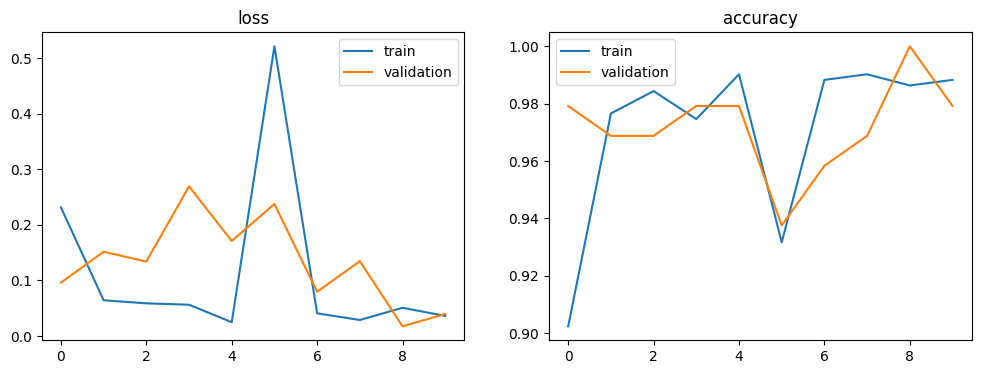

In [98]:
def plot_results(train_loss, valid_loss, train_acc, valid_acc ):
    fig,axs = plt.subplots(1,2,figsize = (12,4))
    axs[0].plot(train_loss.cpu().numpy(), label = 'train')
    axs[0].plot(valid_loss.cpu().numpy(), label = 'validation')
    axs[0].set_title('loss')
    axs[0].legend()
    axs[1].plot(train_acc.cpu().numpy(), label = 'train')
    axs[1].plot(valid_acc.cpu().numpy(), label = 'validation')
    axs[1].set_title('accuracy')
    axs[1].legend()
    plt.show()

plot_results(train_loss, valid_loss, train_acc, valid_acc )